# Seattle AirBnB Pricing Analysis (Udacity Data Science Nano Degree)
#### By K C Sreevasthavan

This analysis is done as a project for Udacity Data Science Nano Degree. 

Source: 
- Data: https://www.kaggle.com/airbnb/seattle/data
- Seatle Shapefile: https://data-seattlecitygis.opendata.arcgis.com/datasets/seattle-streets

### Context
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.

### Content
##### The following Airbnb activity is included in this Seattle dataset:

    - Listings, including full descriptions and average review score
    - Reviews, including unique id for each reviewer and detailed comments
    - Calendar, including listing id and the price and availability for that day

##### Questions Tried to Answer
   - Are there any tend in pricing of house listings?
   - Can you describe which part of Seattle neighborhood has highest review score rating using listing descriptions?
   - Which are the top 5 costliest and cheapest Seattle neighboorhood? 
   
##### References
- Geopandas tutorial: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972


## Business Understanding
Airbnb, Inc. is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. The company does not own any of the real estate listings, nor does it host events; it acts as a broker, receiving commissions from each booking. See more here on [wikipedia](https://en.wikipedia.org/wiki/Airbnb) and official website at [www.airbnb.com](https://www.airbnb.com/)


Basically the its a rental stay service for travellers. There are property listings and user booking those listings using the Airbnb website. User comment review etc. In turn the user pays to airbnb the rent for stay and the airbnb keeps a small charge and pays the host for the accomodation.

Now Let's explore the data and dive right in!

In [66]:
# importing modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

%matplotlib inline
import warnings

In [67]:
# Reading the data
calendar = pd.read_csv('seattle/calendar.csv')
listings = pd.read_csv('seattle/listings.csv')
reviews = pd.read_csv('seattle/reviews.csv')

# Cleaning listings df 
listings.zipcode.replace('99\n98122', '98122', inplace=True)

In [68]:
# Checking calender data
print(calendar.head())
print('\n')
print(calendar.info())

   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None


We can see that price column as well as data columns are object types. 

Also the price column is in $X,XXX.XX format. We need to convert it into XXX.XX format.

So Let's convert them into proper datatype and format.


In [69]:
# converting data column to datetime type
calendar['date'] = pd.to_datetime(calendar['date'])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       934542 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [70]:
# Formatting price column for later use
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

calendar['price'] = calendar['price'].apply(lambda x: clean_currency(x)).astype(float)
# calendar['price'].head()

We can see that if available column is F the price is NaN - which makes sense if the 
property is not listed its prices should not be listed as well. 

Lets confirm if thats the case for all the rows in the data

In [71]:
temp = calendar.groupby('available')['price'].count().reset_index()
print(temp)
print(len(calendar['price'].dropna()))

  available   price
0         f       0
1         t  934542
934542


From the above data we can verify that all the columns with f has price as NaN

And all the values with price t has some or the other price value with is non Nan.

Perfect! now as we have converted the columns into proper datatypes 
and verified the data. 
let's find price trends across the year.


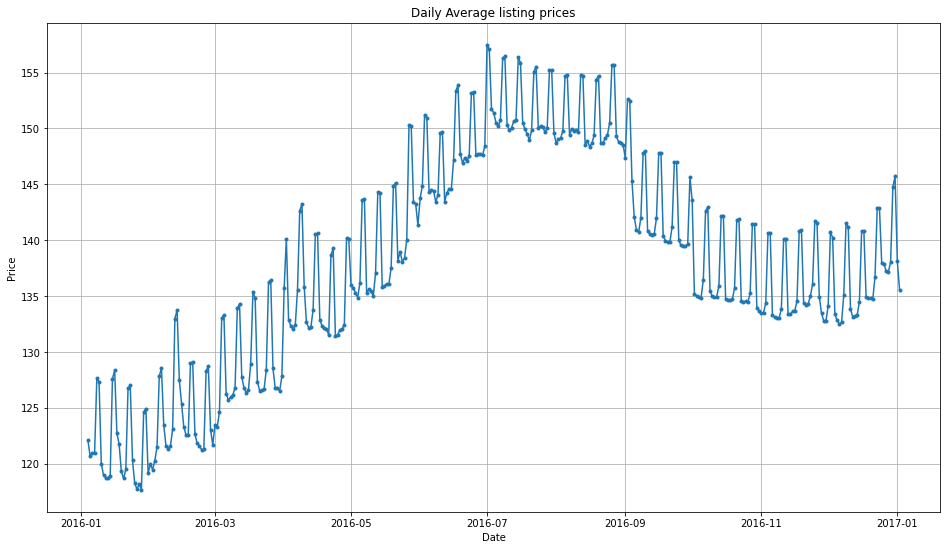

In [72]:
daily_prices = calendar.dropna().groupby('date')['price'].mean().reset_index()

plt.figure(figsize=(16, 9))
plt.plot(daily_prices.date, daily_prices.price, marker='.')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Daily Average listing prices')
plt.grid()
plt.show()

##### Observations
The prices rise from january till july and then falls lowers again till december.
1. Lowest rates are in January - february
2. Highest rates are in July - August

##### Now Lets explore the neighbourhood cost and Quality Trends

In [73]:
# Exploring the data
print(listings.info())
print('\n')
print(listings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

We can see the data contains lots of column data. We are interested in id column and neighbourhood columns especially "neighbourhood_group_cleansed".

Questions:
- Are the ids unique?
- Do we neighbourhood details for all the ids?


In [74]:
listings['id'].drop_duplicates().count()

3818

As the total columns in the listings is equal to total column length we can say that all ids are unique.

In [75]:
print(listings['neighbourhood_group_cleansed'].dropna().count())
print(list(listings['neighbourhood_group_cleansed'].drop_duplicates()))

3818
['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade', 'Central Area', 'University District', 'Downtown', 'Magnolia', 'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley', 'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill', 'Lake City']


We can see that we have neighbourhood_group_clean data for all the columns and there are no null values in the data. 

In [76]:
### Perfect now let's Analyse the neighbourhood wise data

# Finding the top neighbourhood based on review scores.
top_neighbourhood = listings.groupby('neighbourhood_group_cleansed')['review_scores_rating'] \
                    .mean().reset_index().set_index('neighbourhood_group_cleansed') \
                    .sort_values('review_scores_rating', ascending=False)
top_neighbourhood = top_neighbourhood.head(10)

In [77]:
highest_review_scored_neighbourhood = list(top_neighbourhood.index)[:5]
# print(highest_review_scored_neighbourhood)
print('Top 5 neighbourhood in Seattle based on review scores')
for i, x in enumerate(highest_review_scored_neighbourhood):
    print(f"{i+1}. {x}")

Top 5 neighbourhood in Seattle based on review scores
1. Central Area
2. West Seattle
3. Delridge
4. Ballard
5. Queen Anne


In [78]:
# Setting up the geoplot of Seattle

crs = {'init': 'epsg:4326'}

geometry = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
geometry[:3]
geo_df = gpd.GeoDataFrame(listings, # specify data
                          crs=crs, # specify cordinate reference system
                          geometry=geometry # specify geometry list we created
                         )

/Users/vasthav/Udacity/udacityenv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


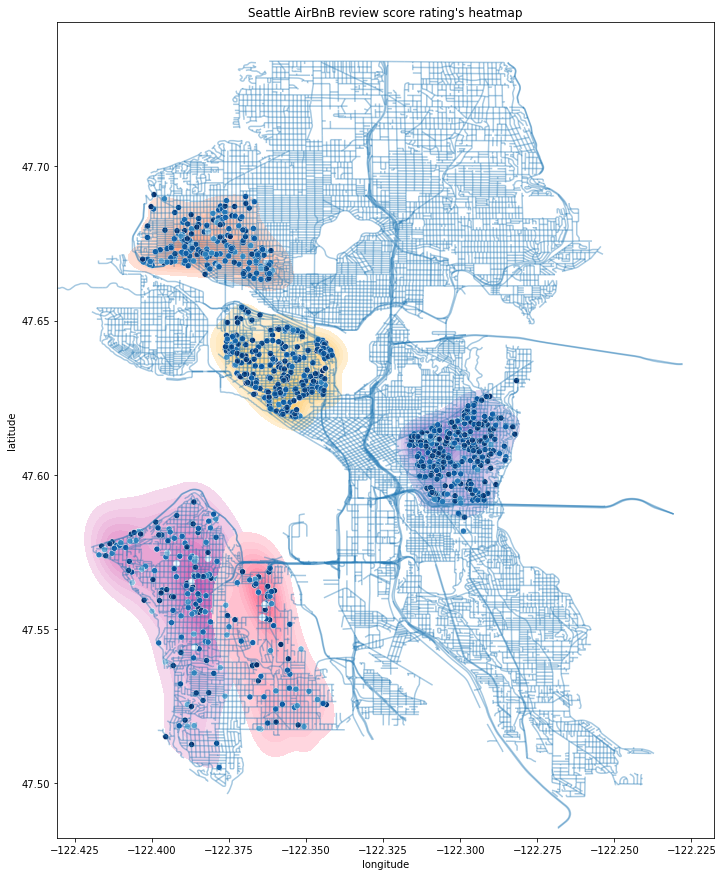

In [79]:
# Plotting the top neighbourd hood in terms of the review scores on Seattle map.

street_map = gpd.read_file('Seattle_Streets/Seattle_Streets.shp')
fig, ax = plt.subplots(figsize = (15,15))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Seattle AirBnB review score rating\'s heatmap')

color = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f']

for index, neighbourhood in enumerate(list(top_neighbourhood.index)[:5]): 
    df_to_plot = geo_df[geo_df.neighbourhood_group_cleansed == neighbourhood]
    sns.light_palette("navy", reverse=True)
    sns.kdeplot(df_to_plot['longitude'],df_to_plot['latitude'], color=color[index], shade=True, shade_lowest=False, n_levels=10) 
    geo_df[geo_df.neighbourhood_group_cleansed == neighbourhood].plot(column='review_scores_rating', cmap='Blues', linewidth=0.5, ax=ax, edgecolor='1' )
street_map.plot(ax = ax, alpha=0.4)

LEGEND
Color coding used for the above geoplot. 
Review score Ranking from 1 ==> 5
['Central Area', 'West Seattle', 'Delridge', 'Ballard', 'Queen Anne']


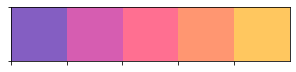

In [80]:
sns.palplot(sns.color_palette(color))
print('LEGEND')
print('======')
print('Color coding used for the above geoplot. \nReview score Ranking from 1 ==> 5')
print(highest_review_scored_neighbourhood)

We have to merge the calendar and listings data based on the listing ids. Lets check if the both listings ids are same set of ids.

In [81]:
calander_ids = list(calendar['listing_id'].drop_duplicates())
listings_ids = list(listings['id'].drop_duplicates())
print(len(calander_ids))
print(len(listings_ids))
set(calander_ids).difference(set(listings_ids))

3818
3818


set()

We can see that they contain equal number of ids and same exact set of ids. Which is exactly what we want.

In [82]:
# Perfect! Lets Find neighbourhood cost trends.

neighbourhood_listings = listings[['id', "neighbourhood_group_cleansed"]].drop_duplicates(keep=False,inplace=False)
neighbourhood_listings.rename(columns={'id': 'listing_id', "neighbourhood_group_cleansed": "neighbourhood"}, inplace=True)
# print(neighbourhood_listings)

In [83]:
listing_costs = calendar.dropna().groupby('listing_id')['price'].mean().reset_index()
# print(listing_costs)

In [84]:
neighbourhood_costs_df = pd.merge(listing_costs, neighbourhood_listings, how='inner', on='listing_id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
neighbourhood_costs = neighbourhood_costs_df.groupby('neighbourhood')['price'].mean().reset_index().sort_values('price', ascending=False)
print(neighbourhood_costs)
costliest_neighbourhood = list(neighbourhood_costs.head()['neighbourhood'])
cheapest_neighbourhood = list(neighbourhood_costs.tail()['neighbourhood'])
cheapest_neighbourhood = cheapest_neighbourhood[::-1]

          neighbourhood       price
9              Magnolia  192.425434
6              Downtown  178.006484
12           Queen Anne  167.467803
3               Cascade  146.140167
16         West Seattle  145.977605
2          Capitol Hill  135.077805
4          Central Area  132.654824
0               Ballard  126.857885
11  Other neighborhoods  125.772435
7              Interbay  117.308887
14          Seward Park  107.844180
15  University District   98.482903
1           Beacon Hill   97.705748
13       Rainier Valley   95.535589
8             Lake City   95.200871
10            Northgate   93.525891
5              Delridge   87.804785


In [85]:
# print({costliest_neighbourhood)
# print(costliest_neighbourhood)
# print(cheapest_neighbourhood)
print('Top 5 Costliest Neighbourhood in Seattle')
for i, x in enumerate(costliest_neighbourhood):
    print(f"{i+1}. {x}")

Top 5 Costliest Neighbourhood in Seattle
1. Magnolia
2. Downtown
3. Queen Anne
4. Cascade
5. West Seattle


In [86]:
print('Top 5 Cheapest Neighbourhood in Seattle')
for i, x in enumerate(cheapest_neighbourhood):
    print(f"{i+1}. {x}")

Top 5 Cheapest Neighbourhood in Seattle
1. Delridge
2. Northgate
3. Lake City
4. Rainier Valley
5. Beacon Hill


In [87]:
cheapest_neighbourhood_listings = listings[listings.neighbourhood_group_cleansed.isin(cheapest_neighbourhood)]
costliest_neighbourhood_listings = listings[listings.neighbourhood_group_cleansed.isin(costliest_neighbourhood)]

/Users/vasthav/Udacity/udacityenv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


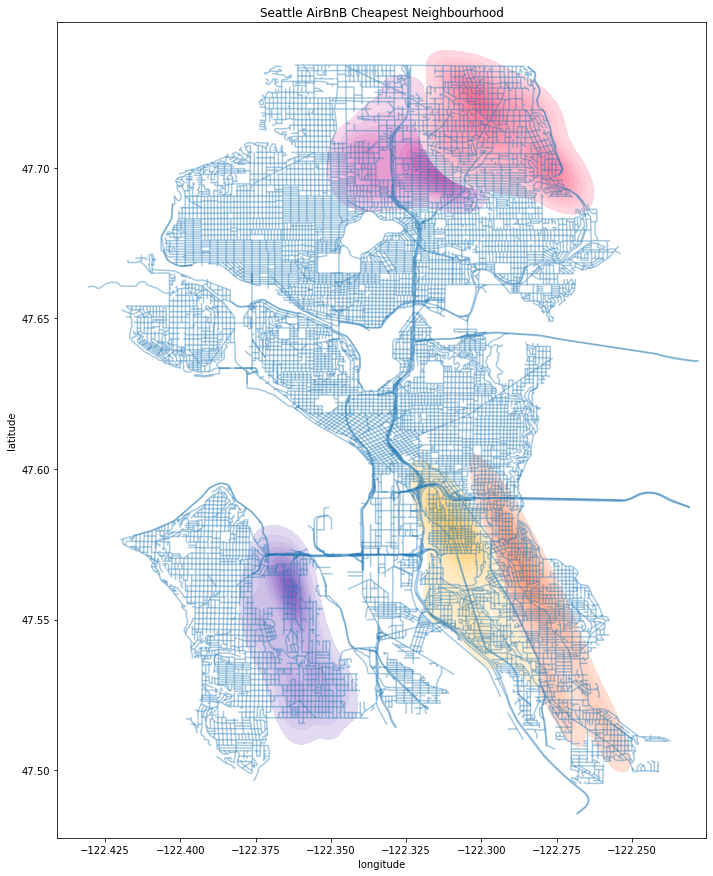

In [88]:
crs = {'init': 'epsg:4326'}

geometry = [Point(xy) for xy in zip(cheapest_neighbourhood_listings['longitude'], cheapest_neighbourhood_listings['latitude'])]
geometry[:3]

geo_df = gpd.GeoDataFrame(cheapest_neighbourhood_listings, # specify data
                          crs=crs, # specify cordinate reference system
                          geometry=geometry # specify geometry list we created
                         )

street_map = gpd.read_file('Seattle_Streets/Seattle_Streets.shp')
fig, ax = plt.subplots(figsize = (15,15))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Seattle AirBnB Cheapest Neighbourhood')

color = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f']

for index, neighbourhood in enumerate(cheapest_neighbourhood): 
    df_to_plot = geo_df[geo_df.neighbourhood_group_cleansed == neighbourhood]
    sns.light_palette("navy", reverse=True)
    sns.kdeplot(df_to_plot['longitude'],df_to_plot['latitude'], color=color[index], shade=True, shade_lowest=False, n_levels=10) 
street_map.plot(ax = ax, alpha=0.4)

LEGEND
Color coding used for the above geoplot. 
Top 5 cheapest neighbourhood Ranking from 1 ==> 5
['Delridge', 'Northgate', 'Lake City', 'Rainier Valley', 'Beacon Hill']


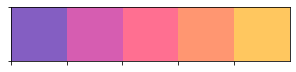

In [89]:
sns.palplot(sns.color_palette(color))
print('LEGEND')
print('======')
print('Color coding used for the above geoplot. \nTop 5 cheapest neighbourhood Ranking from 1 ==> 5')
print(cheapest_neighbourhood)

/Users/vasthav/Udacity/udacityenv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


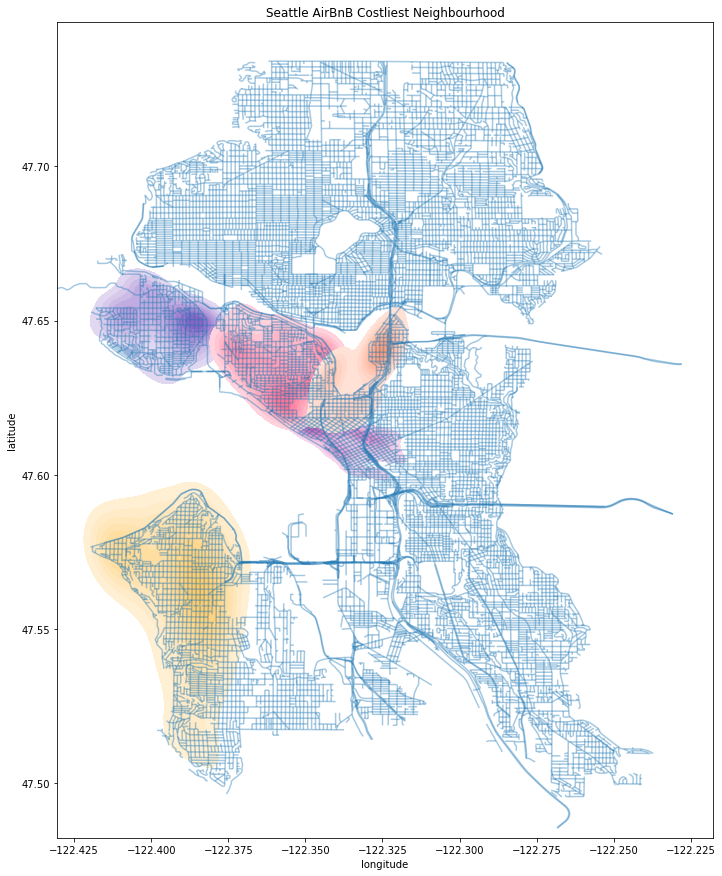

In [90]:
crs = {'init': 'epsg:4326'}

geometry = [Point(xy) for xy in zip(costliest_neighbourhood_listings['longitude'], costliest_neighbourhood_listings['latitude'])]
geometry[:3]

geo_df = gpd.GeoDataFrame(costliest_neighbourhood_listings, # specify data
                          crs=crs, # specify cordinate reference system
                          geometry=geometry # specify geometry list we created
                         )

street_map = gpd.read_file('Seattle_Streets/Seattle_Streets.shp')
fig, ax = plt.subplots(figsize = (15,15))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Seattle AirBnB Costliest Neighbourhood')

color = ['#845ec2', '#d65db1', '#ff6f91', '#ff9671', '#ffc75f']

for index, neighbourhood in enumerate(costliest_neighbourhood): 
    df_to_plot = geo_df[geo_df.neighbourhood_group_cleansed == neighbourhood]
    sns.light_palette("navy", reverse=True)
    sns.kdeplot(df_to_plot['longitude'],df_to_plot['latitude'], color=color[index], shade=True, shade_lowest=False, n_levels=10) 
street_map.plot(ax = ax, alpha=0.4)

LEGEND
Color coding used for the above geoplot. 
Top 5 costliest neighbourhood Ranking from 5 ==> 1
['Magnolia', 'Downtown', 'Queen Anne', 'Cascade', 'West Seattle']


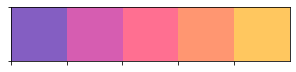

In [91]:
sns.palplot(sns.color_palette(color))
print('LEGEND')
print('======')
print('Color coding used for the above geoplot. \nTop 5 costliest neighbourhood Ranking from 5 ==> 1')
print(costliest_neighbourhood)

### Conclusions

1. Are there any tend in pricing of house listings?
   
   The prices rise from january till july and then falls lowers again till december.
        1. Lowest rates are in January - february
        2. Highest rates are in July - August
2. Can you describe which part of Seattle neighborhood has highest review score rating using listing descriptions?
   
   Top 5 neighbourhood in Seattle based on review scores
        1. Central Area
        2. West Seattle
        3. Delridge
        4. Ballard
        5. Queen Anne

3. Which are the top 5 costliest and cheapest Seattle neighboorhood? 

    Top 5 Costliest Neighbourhood in Seattle
        1. Magnolia
        2. Downtown
        3. Queen Anne
        4. Cascade
        5. West Seattle
        
    Top 5 Cheapest Neighbourhood in Seattle
        1. Delridge
        2. Northgate
        3. Lake City
        4. Rainier Valley
        5. Beacon Hill

We can see from the points 2 and 3 that 
 1. West Seattle and Queen Anne are two highly rated places which are amoung the top 5 costliest neighbourhood in Seattle.
 2. Delridge is the one the highly rated places which is amoung the top 5 cheapest neighbourhood in Seattle.
